# Google Play Store Exploratory Analysis

Dataset available on https://www.kaggle.com/lava18/google-play-store-apps

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

sns.set_theme(style='darkgrid', palette='Set3')

# Loading and checking datasets

In [2]:
df_apps = pd.read_csv('datasets/googleplaystore.csv')
df_apps.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [3]:
df_apps.shape

(10841, 13)

In [4]:
df_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
df_apps.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
df_reviews = pd.read_csv('datasets/googleplaystore_user_reviews.csv')
df_reviews.head(3)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN


In [7]:
df_reviews.shape

(64295, 5)

In [8]:
df_reviews.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

# Data Cleaning

## Deleting irrelevant data

In [9]:
df_apps.drop(['Last Updated', 'Current Ver'], axis=1, inplace=True)
df_apps.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,4.0.3 and up


## Dealing with missing information

### Type

* There's only 1 App without 'Type', so we'll be fixing this manually

In [10]:
df_apps[df_apps['Type'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,Varies with device


In [11]:
# Type according to Google Play Store (23/03/21)
type_column = df_apps.columns.get_loc('Type')
df_apps.iloc[9148, type_column] = 'Free'

In [12]:
df_apps['Type'].value_counts()

Free    10040
Paid      800
0           1
Name: Type, dtype: int64

* There's 1 App with 'Type' = 0. Let's take a look at it:

In [13]:
df_apps[df_apps['Type'] == '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",NaN


* This row values have been misplaced. We'll be fixing it:

In [14]:
df_apps.iloc[10472] = df_apps.iloc[10472].shift(periods=1)
df_apps.iloc[10472, 0] = df_apps.iloc[10472].loc['Category']
df_apps.iloc[10472, 1] = 'LIFESTYLE'
df_apps.iloc[10472, -2] = 'Lifestyle'
df_apps.iloc[10472, -1] = '4.0 and up'

In [15]:
df_apps['Type'].value_counts()

Free    10041
Paid      800
Name: Type, dtype: int64

### Android Ver

* There are 2 Apps without 'Android Ver'. We'll be filling them with the most common Android Version

In [16]:
most_common_android = df_apps['Android Ver'].value_counts().idxmax()
df_apps['Android Ver'].fillna(most_common_android, inplace=True)

### Rating

* There are a lot of 'NaN' values in this column. 
* We'll be filling them with '0'.

In [17]:
df_apps['Rating'].fillna(0, inplace=True)

### Reviews

* We'll be dropping the 'NaN' values in the review dataset.

In [18]:
df_reviews.dropna(inplace=True)

In [19]:
df_reviews.isna().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

## Changing data types

### Review

* Change datatype to numeric

In [20]:
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'])

### Installs

* Remove (+ ,) and change datatype to numeric

In [21]:
df_apps['Installs'] = df_apps['Installs'].apply(lambda x: float(x[:-1].replace(',', '')) if x[-1] == '+' else float(x))

### Size

* Convert the App Size to megabytes (Size will be 0 if 'Varies with Device')

In [22]:
df_apps['Size'] = df_apps['Size'].apply(lambda x: float(x[:-1]) if x[-1] == 'M' else(float(x[:-1])/1024 if x[-1] == 'k' else 0))

### Price

* Remove ($) and change datatype to numeric 

In [23]:
df_apps['Price'] = df_apps['Price'].apply(lambda x: float(x[1:]) if x[0] == '$' else float(x))

### Android Version

* Get only the 'integer' number corresponding to the android version

In [24]:
df_apps['Android Ver'] = df_apps['Android Ver'].apply(lambda x: x.split('.')[0])

### Rating

In [25]:
df_apps['Rating'] = pd.to_numeric(df_apps['Rating'])

### Rename column

In [26]:
df_apps.rename(columns={'Installs': 'Downloads'}, inplace=True)

# Visualization

### Overview

In [27]:
print(f'This dataset contains {df_apps.shape[0]} Android Apps')

This dataset contains 10841 Android Apps


In [28]:
print(f"There are {df_apps['Category'].unique().shape[0]} different App Categories")

There are 33 different App Categories


### Most common Google Play Apps Category

* What are the most common app categories on Google Play Store?

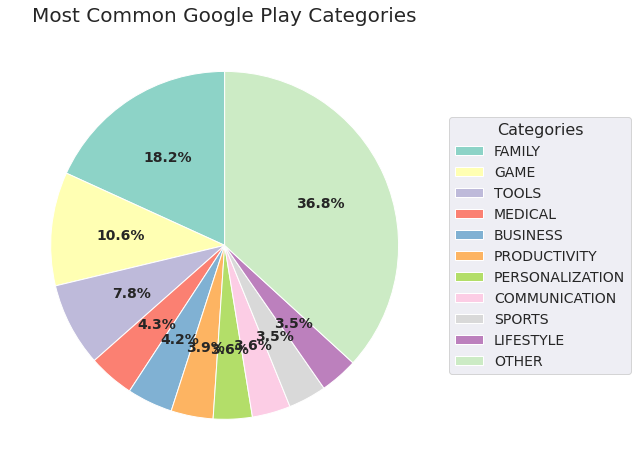

In [29]:
common_categories = df_apps['Category'].value_counts()

# Generate Labels and Values
labels = common_categories.head(10).index.tolist()
labels.append('OTHER')
values = common_categories.head(10).values.tolist()
values.append(df_apps.shape[0] - common_categories.head(10).sum())

# Plot
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels, title='Categories', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), title_fontsize=16, fontsize=14)
plt.setp(autotexts, size=14, weight='bold')
ax.set_title("Most Common Google Play Categories", fontsize=20)
plt.savefig('visualization/most-common-categories-pieplot.png', bbox_inches='tight')
plt.show()

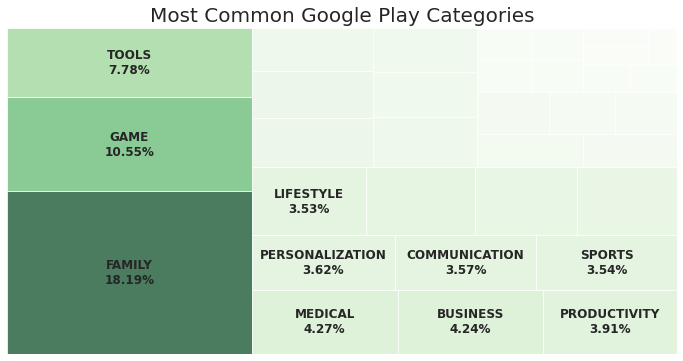

In [30]:
# Generate Labels and Values
values = common_categories.values
percentage = (values * 100 / values.sum()).round(2)
labels = common_categories.index + '\n' + percentage.astype('str') + '%'

# Generate Colormap
cmap = matplotlib.cm.Greens
mini = min(common_categories)
maxi = max(common_categories)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in common_categories]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
squarify.plot(values, label=labels[:10], color=colors, alpha=0.7, text_kwargs={'fontsize': 12, 'weight': 'bold'})
ax.axis('off')
ax.set_title("Most Common Google Play Categories", fontsize=20)
plt.savefig('visualization/most-common-categories-squareplot.png', bbox_inches='tight')
plt.show()

* <strong>Family</strong>, <strong>Game</strong> and <strong>Tools</strong> are the most common app categories (in number of apps)

* The <strong>other</strong> 30 categories represent <strong>63.5%</strong> of the applications. But <strong>each category</strong> is responsible for <strong>less than 5%</strong> of the applications.

### Most Popular Google Play Categories (in number of downloads)

* What are the most popular app categories on Google Play Store? (number of downloads)

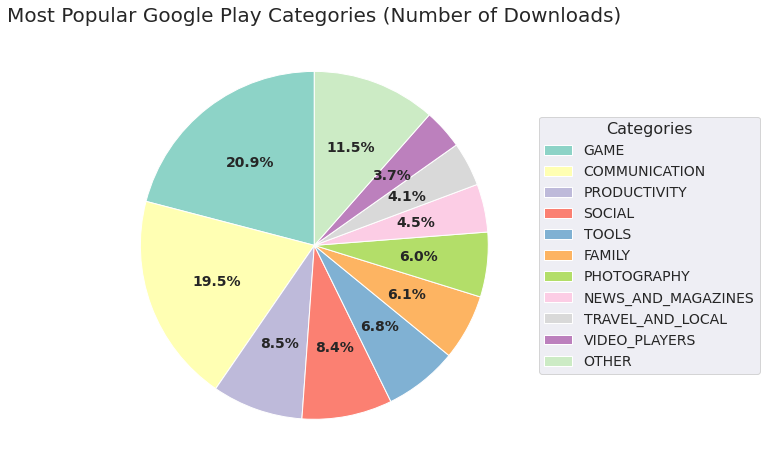

In [31]:
popular_categories_downloads = df_apps.groupby(['Category'])['Downloads'].sum().sort_values(ascending=False)

# Generate Labels and Values
labels_top10 = popular_categories_downloads.head(10).index.tolist()
labels_top10.append('OTHER')
values_top10 = popular_categories_downloads.head(10).values.tolist()
values_top10.append(df_apps['Downloads'].sum() - popular_categories_downloads.head(10).sum())

# Plot
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values_top10, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.legend(wedges, labels_top10, title='Categories', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), title_fontsize=16, fontsize=14)
plt.setp(autotexts, size=14, weight='bold')
ax.set_title("Most Popular Google Play Categories (Number of Downloads)", fontsize=20)
plt.savefig('visualization/most-popular-categories-pieplot.png', bbox_inches='tight')
plt.show()

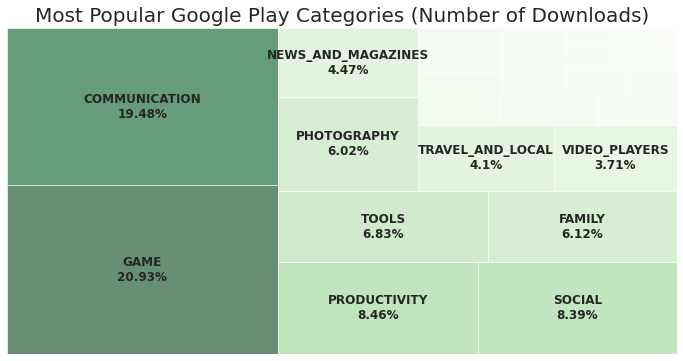

In [32]:
# Generate Labels and Values
values = popular_categories_downloads.values
percentage = (values * 100 / values.sum()).round(2)
labels = popular_categories_downloads.index + '\n' + percentage.astype('str') + '%'

# Generate Colormap
cmap = matplotlib.cm.Greens
mini = min(popular_categories_downloads)
maxi = max(popular_categories_downloads)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in popular_categories_downloads]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
squarify.plot(values, label=labels[:10], color=colors, alpha=0.6, text_kwargs={'fontsize': 12, 'weight': 'bold'})
ax.axis('off')
ax.set_title("Most Popular Google Play Categories (Number of Downloads)", fontsize=20)
plt.savefig('visualization/most-popular-categories-squareplot.png', bbox_inches='tight')
plt.show()

* <strong>Game</strong> and <strong>Communication</strong> are the most popular app categories. <strong>Together</strong> they are responsible for about <strong>40% of all Google Play Store downloads</strong>.

### Rating Distribution (Overall)

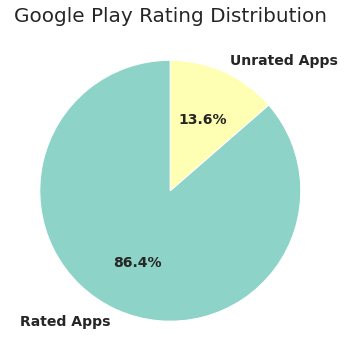

In [33]:
rated_apps = pd.DataFrame(df_apps[df_apps['Rating'] > 0])
unrated_apps = df_apps[df_apps['Rating'] == 0]

# Generate Labels and Values
values = [rated_apps.shape[0], unrated_apps.shape[0]]
labels = ['Rated Apps', 'Unrated Apps']

# Plot
fig, ax = plt.subplots(figsize=(10,6))
wedges, text, autotexts = ax.pie(values, labels=labels, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14, 'weight': 'bold'})
ax.set_title("Google Play Rating Distribution", fontsize=20)
plt.savefig('visualization/rating-distribution-overall.png', bbox_inches='tight')
plt.show()

* The <strong>majority</strong> (86.4%) of the Google Play Apps <strong>receive a user rating</strong>.

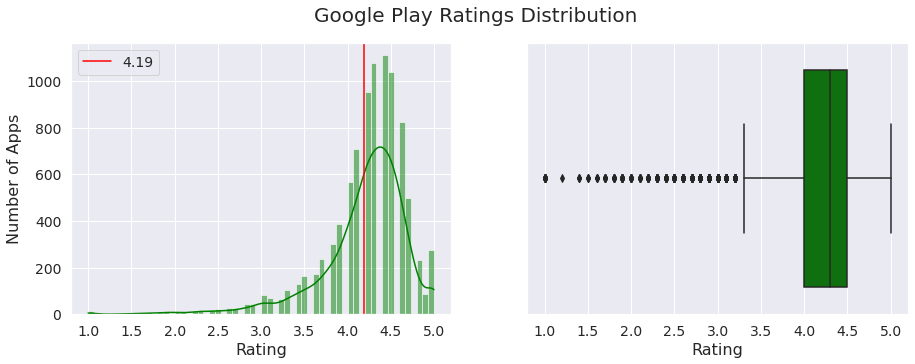

In [34]:
mean = rated_apps['Rating'].mean()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Google Play Ratings Distribution', fontsize=20)

sns.histplot(ax=axs[0], data=rated_apps['Rating'], kde=True, color='g', bins=60)
axs[0].tick_params(labelsize=14)
axs[0].set_ylabel('Number of Apps', fontsize=16)
axs[0].set_xlabel('Rating', fontsize=16)
axs[0].axvline(mean, color='r', linestyle='-', label=str(mean.round(2)))

sns.boxplot(ax=axs[1], x=rated_apps['Rating'], color='g')
axs[1].tick_params(labelsize=14)
axs[1].set_xlabel('Rating', fontsize=16)
axs[0].legend(fontsize=14)

plt.savefig('visualization/rating-distribution-histplot-boxplot.png', bbox_inches='tight')
plt.show()

* <strong>Most</strong> Google Play Apps have <strong>good ratings (4.0 ~ 4.5)</strong>

In [35]:
print(f"The average app rating is {mean:.2f}")

The average app rating is 4.19


### Rating Distribution (across the 3 most popular categories)

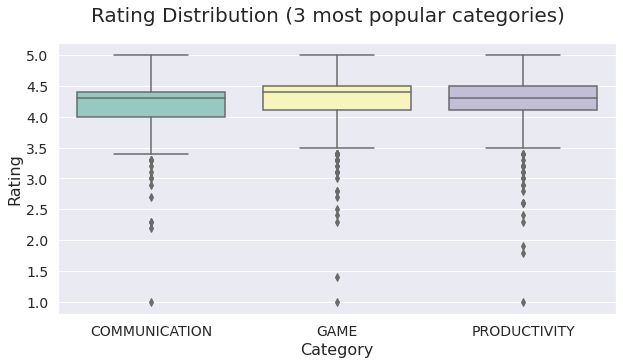

In [36]:
# Get ratings of the 3 most popular categories
top3_categories = popular_categories_downloads.head(3).index.tolist()
ratings_top3_categories = rated_apps[rated_apps['Category'].isin(top3_categories)]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, x='Category', y='Rating', data=ratings_top3_categories)
fig.suptitle('Rating Distribution (3 most popular categories)', fontsize=20)
ax.set_ylabel('Rating', fontsize=16)
ax.set_xlabel('Category', fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('visualization/rating-distribution-popular-categories.png', bbox_inches='tight')
plt.show()

* The rating distribution is <strong>similar</strong> across the <strong>3 most popular app categories</strong>

### Rating Distribution (Free Apps x Paid Apps)

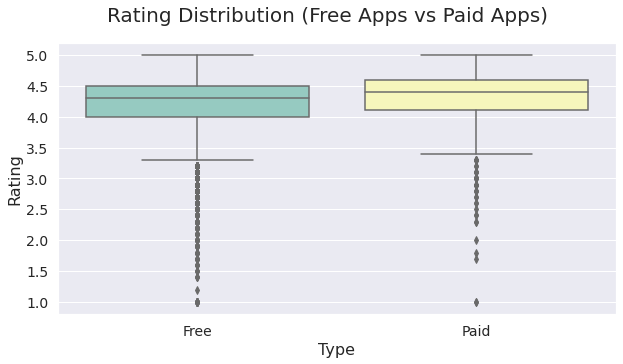

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(ax=ax, x='Type', y='Rating', data=rated_apps)
fig.suptitle('Rating Distribution (Free Apps vs Paid Apps)', fontsize=20)
ax.set_ylabel('Rating', fontsize=16)
ax.set_xlabel('Type', fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('visualization/rating-distribution-paid-x-free.png', bbox_inches='tight')
plt.show()

* The rating distribution is <strong>similar</strong> between <strong>Paid and Free apps</strong>

### App pricing strategy

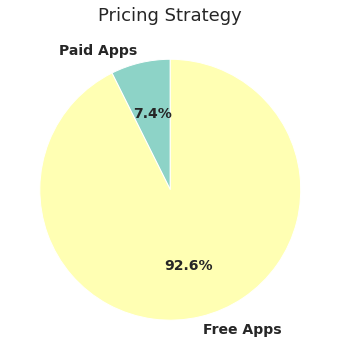

In [38]:
paid_apps = df_apps[df_apps['Type'] == 'Paid']
free_apps = df_apps[df_apps['Type'] == 'Free']

values = [paid_apps.shape[0], free_apps.shape[0]]
labels = ['Paid Apps', 'Free Apps']

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.pie(values, labels=labels, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14, 'weight': 'bold'})
ax.set_title("Pricing Strategy", fontsize=18)
plt.savefig('visualization/pricing-strategy-free-x-paid.png', bbox_inches='tight')
plt.show()

* <strong>Most</strong> of the apps available on Google Play Store are <strong>Free</strong>.

<AxesSubplot:xlabel='Price'>

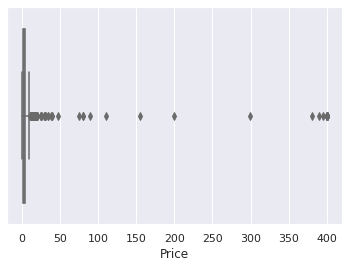

In [39]:
sns.boxplot(x=paid_apps['Price'])

* In order to have a better visualization, we'll identify and remove the outliers

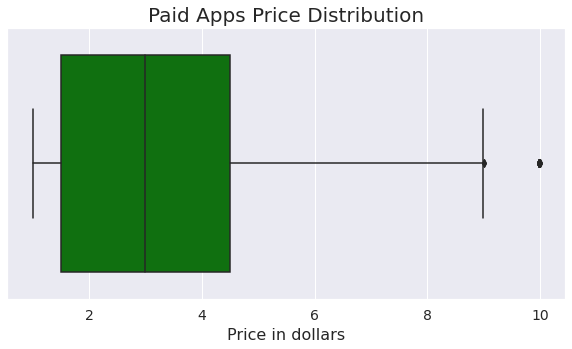

In [40]:
# Removing outliers
Q1 = paid_apps['Price'].quantile(.25)
Q3 = paid_apps['Price'].quantile(.75)
IIQ = Q3 - Q1
lower_limit = Q1 - 1.5 * IIQ
upper_limit = Q3 + 1.5 * IIQ

selection = (paid_apps['Price'] >= lower_limit) & (paid_apps['Price'] <= upper_limit)
paid_apps_select = paid_apps[selection]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x=paid_apps_select['Price'], color='g')
ax.set_title('Paid Apps Price Distribution', fontsize=20)
ax.set_xlabel('Price in dollars', fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('visualization/paid-apps-price-distribution.png', bbox_inches='tight')
plt.show()

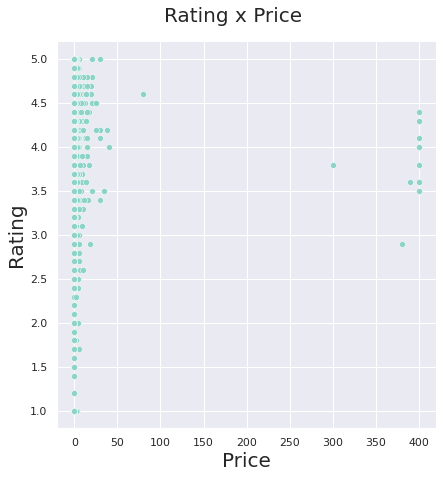

In [41]:
rel = sns.relplot(x='Price', y='Rating', data=rated_apps, height=6)
rel.fig.suptitle('Rating x Price', y=1.05, fontsize=20)
rel.set_axis_labels('Price', 'Rating', fontsize=20)
plt.savefig('visualization/rating-x-price.png', bbox_inches='tight')
plt.show()

* Paid Apps <strong>prices</strong> usually range from <strong>1.5 to 4 dollars.</strong>. And most of the top rated apps are also placed in this range.

### App Size Distribution

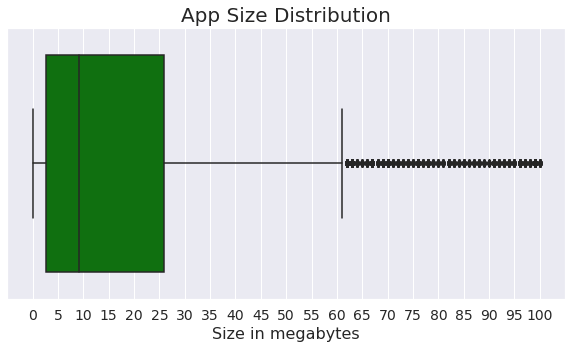

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=df_apps['Size'], color='g')
ax.set_title('App Size Distribution', fontsize=20)
ax.set_xlabel('Size in megabytes', fontsize=16)
ax.set_xticks(range(0, int(max(df_apps['Size'])) + 1, 5))
ax.tick_params(labelsize=14)
plt.savefig('visualization/app-size-distribution.png', bbox_inches='tight')
plt.show()

* Apps <strong>sizes</strong> usually range from <strong>2 to 26 megabytes</strong>

### Content Rating Distribution

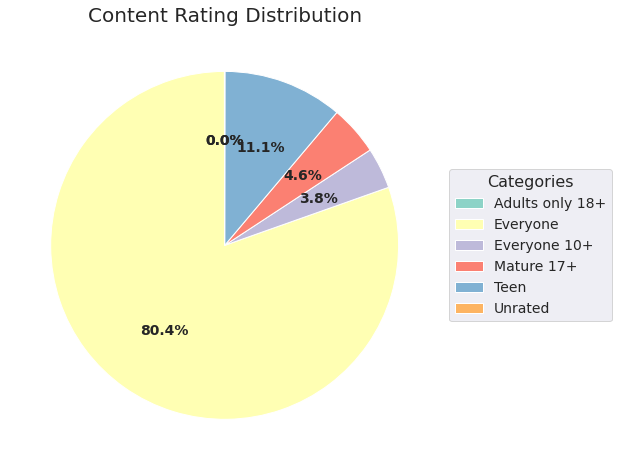

In [43]:
content_rating_count = df_apps.groupby(['Content Rating']).size()

# Generate Labels and Values
labels = content_rating_count.index
values = content_rating_count.values

# Plot
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels, title='Categories', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), title_fontsize=16, fontsize=14)
plt.setp(autotexts, size=14, weight='bold')
ax.set_title("Content Rating Distribution", fontsize=20)
plt.savefig('visualization/content-rating-distribution.png', bbox_inches='tight')
plt.show()

* The <strong>majority</strong> (80.4%) of the Google Play Apps are directed towards people of <strong>all ages</strong>.

### Minimum Android Version Required

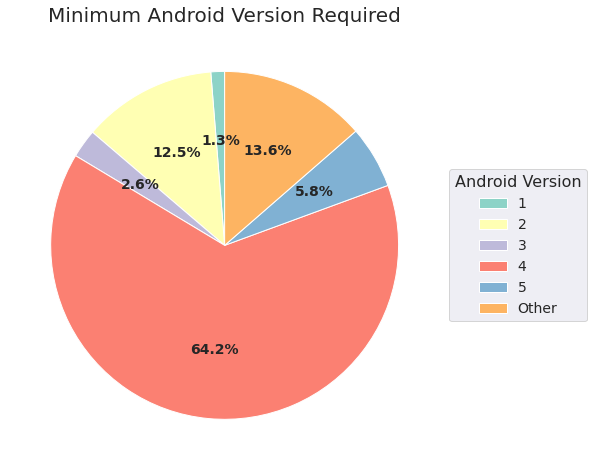

In [44]:
android_version_cont = df_apps.groupby(['Android Ver']).size()

# Organize android version categories
android_version_cont = android_version_cont[android_version_cont > 100]
android_version_cont.drop(['Varies with device'], inplace=True)
other = pd.Series([df_apps.shape[0] - android_version_cont.sum()], index=['Other'])
android_version_cont = android_version_cont.append(other)

# Generate Labels and Values
labels = android_version_cont.index
values = android_version_cont.values

# Plot
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels, title='Android Version', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), title_fontsize=16, fontsize=14)
plt.setp(autotexts, size=14, weight='bold')
ax.set_title("Minimum Android Version Required", fontsize=20)
plt.savefig('visualization/minimum-android-version-required.png', bbox_inches='tight')
plt.show()

* <strong>Most of the Google Play Apps (64.2%)</strong> require the user to have a device running at <strong>least Android 4.0</strong> (which was launched in 2011/12)

### Most common words in reviews (Wordcloud)

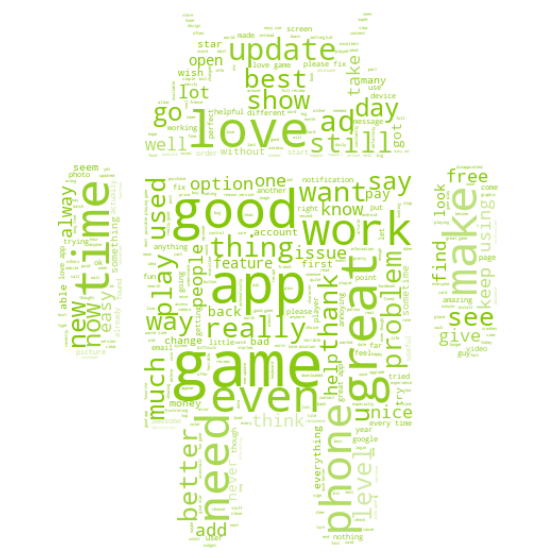

In [45]:
# Mask image config
mask = np.array(Image.open('imgs/mask-image.png'))
mask[mask==0] = 255

# Wordcloud config
text = ' '.join(df_reviews['Translated_Review']).lower()
wordcloud = WordCloud(background_color='white', max_words=400, mask=mask, stopwords=STOPWORDS, max_font_size=60, random_state=11)
wordcloud.generate(text)
image_colors = ImageColorGenerator(mask)

# Plot
plt.figure(figsize=[15,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.savefig('visualization/most-common-words.png', bbox_inches='tight')
plt.show()